<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/Bridge_Cracks/Bridge_Cracks_MobileNetV2_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================
# EfficientNetB0 for Bridge Cracks (Single Folder)
# ==============================================

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ----------------------------
# 2. Imports
# ----------------------------
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ----------------------------
# 3. Dataset Path
# ----------------------------
dataset_dir = '/content/drive/MyDrive/Bridge_Cracks'  # contains Positive & Negative subfolders

# ----------------------------
# 4. Detect Image Size Automatically
# ----------------------------
import cv2
sample_class = os.listdir(dataset_dir)[0]
sample_image_path = os.path.join(dataset_dir, sample_class, os.listdir(os.path.join(dataset_dir, sample_class))[0])
sample_image = cv2.imread(sample_image_path)
img_height, img_width = sample_image.shape[:2]
print(f"Detected image size: {img_height}x{img_width}")

# ----------------------------
# 5. Load Dataset with 80/20 Split
# ----------------------------
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ----------------------------
# 6. Data Augmentation
# ----------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# ----------------------------
# 7. Build Model (Fine-tuning) – MobileNetV2
# ----------------------------
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = True  # fine-tune all layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ----------------------------
# 8. Train Model
# ----------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Detected image size: 200x200
Found 3801 files belonging to 2 classes.
Using 3041 files for training.
Found 3801 files belonging to 2 classes.
Using 760 files for validation.
Classes: ['Negative', 'Positive']


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 4,335,998 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 159s 747ms/step - accuracy: 0.7881 - loss: 0.4385 - val_accuracy: 0.9763 - val_loss: 0.1358
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 318ms/step - accuracy: 0.9685 - loss: 0.0981 - val_accuracy: 0.9921 - val_loss: 0.0354
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 313ms/step - accuracy: 0.9770 - loss: 0.0685 - val_accuracy: 0.9908 - val_loss: 0.0331
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 312ms/step - accuracy: 0.9781 - loss: 0.0610 - val_accuracy: 0.9921 - val_loss: 0.0276
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 34s 351ms/step - accuracy: 0.9841 - loss: 0.0529 - val_accuracy: 0.9882 - val_loss: 0.0344
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 34s 341ms/step - accuracy: 0.9859 - loss: 0.0431 - val_accuracy: 0.9921 - val_loss: 0.0250
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 38s 313ms/step - accuracy: 0.9849 - loss: 0.0540 - val_accuracy: 0.9921 - val_loss: 0.0245
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 317ms/step - accuracy: 0.9865 - loss: 0.0425 - val_acc

In [ ]:
# ----------------------------
# 9. Extract predictions and true labels
# ----------------------------
def get_labels_and_predictions(dataset, model):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    return np.array(y_true), np.array(y_pred)

# For training dataset
y_true_train, y_pred_train = get_labels_and_predictions(train_ds, model)

# For validation dataset
y_true_val, y_pred_val = get_labels_and_predictions(val_ds, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
# ----------------------------
# Define metrics_df function
# ----------------------------
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def metrics_df(y_true, y_pred, dataset_name):
    """Compute key classification metrics and return as DataFrame."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Optional: confusion matrix display
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix ({dataset_name}):\n", cm)

    # Return DataFrame with metrics
    df = pd.DataFrame({
        'Dataset': [dataset_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1]
    })
    return df


In [ ]:
# ----------------------------
# 10. Calculate metrics and display as DataFrame
# ----------------------------
df_train_metrics = metrics_df(y_true_train, y_pred_train, "Training")
df_val_metrics = metrics_df(y_true_val, y_pred_val, "Validation")

# Combine into one DataFrame
df_metrics = pd.concat([df_train_metrics, df_val_metrics], ignore_index=True)
df_metrics



Confusion Matrix (Training):
 [[2220    2]
 [   5  814]]

Confusion Matrix (Validation):
 [[546   4]
 [  3 207]]


,Dataset,Accuracy,Precision,Recall,F1-Score
0,Training,0.997698,0.997698,0.997698,0.997697
1,Validation,0.990789,0.990807,0.990789,0.990796


In [ ]:
df_metrics

,Dataset,Accuracy,Precision,Recall,F1-Score
0,Training,0.997698,0.997698,0.997698,0.997697
1,Validation,0.990789,0.990807,0.990789,0.990796


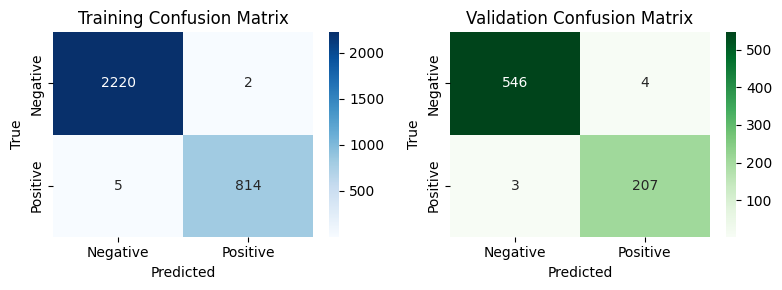

In [ ]:
# Confusion matrices
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_val = confusion_matrix(y_true_val, y_pred_val)

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices_train_val.png')
plt.show()


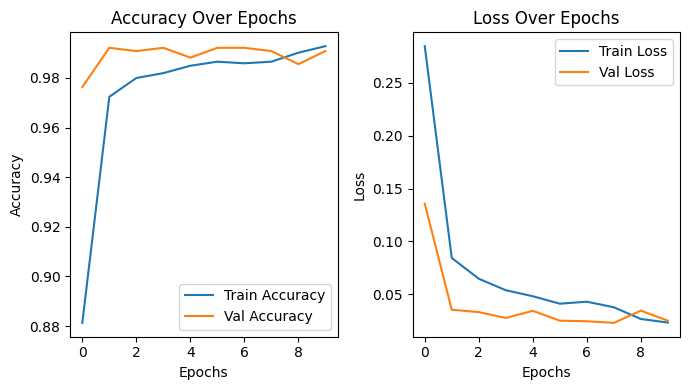

In [ ]:
# ----------------------------
# 10. Accuracy & Loss Plots
# ----------------------------
plt.figure(figsize=(7,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('accuracy_loss.png')
plt.show()

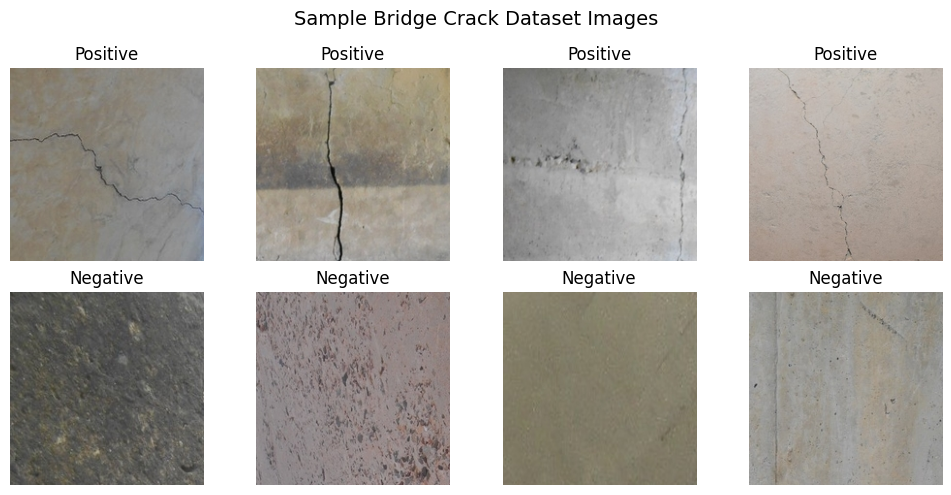

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import random

# Paths for Positive and Negative subfolders
positive_dir = os.path.join(dataset_dir, "Positive")
negative_dir = os.path.join(dataset_dir, "Negative")

# Pick 4 random samples from each class
positive_samples = random.sample(os.listdir(positive_dir), 4)
negative_samples = random.sample(os.listdir(negative_dir), 4)

# Plot figure
fig, axes = plt.subplots(2, 4, figsize=(10,5))

# First row: Positive cracks
for i, img_name in enumerate(positive_samples):
    img_path = os.path.join(positive_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, i].imshow(img)
    axes[0, i].set_title("Positive")
    axes[0, i].axis("off")

# Second row: Negative (no cracks)
for i, img_name in enumerate(negative_samples):
    img_path = os.path.join(negative_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1, i].imshow(img)
    axes[1, i].set_title("Negative")
    axes[1, i].axis("off")

plt.suptitle("Sample Bridge Crack Dataset Images", fontsize=14)
plt.tight_layout()
plt.savefig("sample_bridge_crack_images.png")
plt.show()


In [ ]:
# ----------------------------
# Original image size
# ----------------------------
import cv2, os, numpy as np

dataset_dir = '/content/drive/MyDrive/Bridge_Cracks'
sample_class = os.listdir(dataset_dir)[0]
sample_image_path = os.path.join(dataset_dir, sample_class, os.listdir(os.path.join(dataset_dir, sample_class))[0])
sample_image = cv2.imread(sample_image_path)
orig_height, orig_width = sample_image.shape[:2]
print(f"Original image size: {orig_height}x{orig_width}")

# ----------------------------
# EfficientNet input size
# ----------------------------
from tensorflow.keras.applications import EfficientNetB0
input_shape = EfficientNetB0(weights='imagenet').input_shape[1:3]  # (224, 224) by default
print(f"EfficientNetB0 input size: {input_shape[0]}x{input_shape[1]}")

# ----------------------------
# Count samples per class
# ----------------------------
from tensorflow.keras.preprocessing import image_dataset_from_directory

batch_size = 32
train_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=input_shape,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=input_shape,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Count positive and negative samples
def count_samples(dataset):
    counts = {name: 0 for name in class_names}
    for _, labels in dataset:
        for i, name in enumerate(class_names):
            counts[name] += np.sum(labels.numpy() == i)
    return counts

train_counts = count_samples(train_ds)
val_counts = count_samples(val_ds)

print("Training samples:", train_counts)
print("Validation samples:", val_counts)


Original image size: 200x200
EfficientNetB0 input size: 224x224
Found 3801 files belonging to 2 classes.
Using 3041 files for training.
Found 3801 files belonging to 2 classes.
Using 760 files for validation.
Training samples: {'Negative': np.int64(2222), 'Positive': np.int64(819)}
Validation samples: {'Negative': np.int64(550), 'Positive': np.int64(210)}


In [ ]:
train_count = tf.data.experimental.cardinality(train_ds).numpy() * batch_size
val_count = tf.data.experimental.cardinality(val_ds).numpy() * batch_size

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Approximate number of training images: {train_count}")
print(f"Approximate number of validation images: {val_count}")


Number of training batches: 96
Number of validation batches: 24
Approximate number of training images: 3072
Approximate number of validation images: 768


In [ ]:
total_images = sum(len(files) for _, _, files in os.walk(dataset_dir) if files)
train_size = int(0.8 * total_images)
val_size = total_images - train_size

print(f"Total images: {total_images}")
print(f"Training images: {train_size}")
print(f"Validation images: {val_size}")


Total images: 3801
Training images: 3040
Validation images: 761


In [ ]:
def plot_combined_roc(train_ds, val_ds, model, num_classes):
    """Plot ROC curves for training and validation datasets together."""
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    import numpy as np

    y_true_train, y_probs_train = get_probabilities_and_labels(train_ds, model)
    y_true_val, y_probs_val = get_probabilities_and_labels(val_ds, model)

    fig, ax = plt.subplots(figsize=(7,6))

    if num_classes == 2:
        fpr_train, tpr_train, _ = roc_curve(y_true_train, y_probs_train[:, 1])
        fpr_val, tpr_val, _ = roc_curve(y_true_val, y_probs_val[:, 1])
        auc_train = auc(fpr_train, tpr_train)
        auc_val = auc(fpr_val, tpr_val)

        ax.plot(fpr_train, tpr_train, lw=2, label=f"Training (AUC = {auc_train:.3f})")
        ax.plot(fpr_val, tpr_val, lw=2, label=f"Validation (AUC = {auc_val:.3f})")

    else:
        y_true_train_bin = label_binarize(y_true_train, classes=range(num_classes))
        y_true_val_bin = label_binarize(y_true_val, classes=range(num_classes))
        for i in range(num_classes):
            fpr_train, tpr_train, _ = roc_curve(y_true_train_bin[:, i], y_probs_train[:, i])
            fpr_val, tpr_val, _ = roc_curve(y_true_val_bin[:, i], y_probs_val[:, i])
            auc_train = auc(fpr_train, tpr_train)
            auc_val = auc(fpr_val, tpr_val)
            ax.plot(fpr_train, tpr_train, lw=2, label=f"Train Class {i} (AUC={auc_train:.3f})")
            ax.plot(fpr_val, tpr_val, lw=2, linestyle='--', label=f"Val Class {i} (AUC={auc_val:.3f})")

    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_title("ROC Curves - Training vs Validation")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right", fontsize=8)
    ax.grid(True)

    return fig  # return figure object


In [ ]:
def get_probabilities_and_labels(dataset, model):
    import numpy as np
    y_true = []
    y_pred_probs = []

    for images, labels in dataset:
        probs = model.predict(images, verbose=0)
        y_true.append(labels.numpy())
        y_pred_probs.append(probs)

    y_true = np.concatenate(y_true)
    y_pred_probs = np.concatenate(y_pred_probs)

    return y_true, y_pred_probs


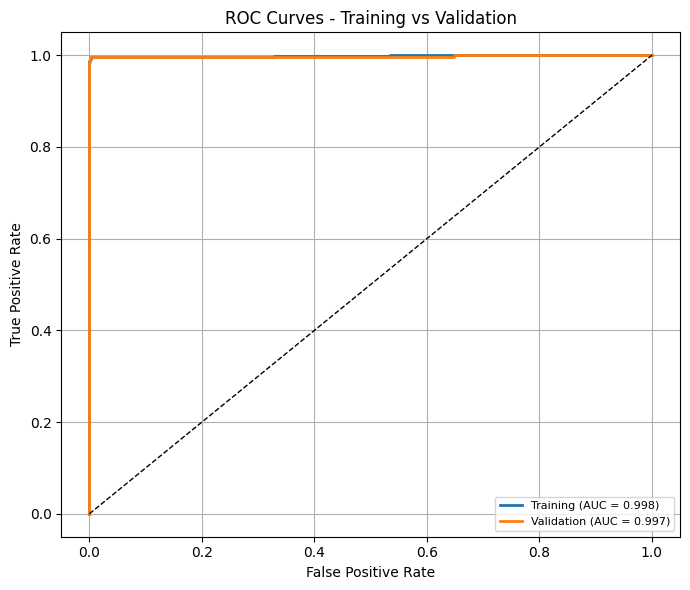

In [ ]:
fig = plot_combined_roc(train_ds, val_ds, model, num_classes)
plt.tight_layout()
fig.savefig("ROC_curves.png")
plt.show()
